<a href="https://colab.research.google.com/github/HarshdeepS1/ML_Project_Depression_Study/blob/main/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depression

## Setup

First, let's import the necessary libraries.

In [ ]:
import os
import numpy as np
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FuncFormatter
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import log_loss, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from collections import Counter
import numpy.random as r # We will randomly initialize our weights
%matplotlib inline


Next, let's download the [dataset](https://www.kaggle.com/datasets/adilshamim8/student-depression-dataset/data) from Kaggle. The features we are using are gender, age, academic pressure, study satisfaction, sleep duration, dietary habits, suicidal thoughts, study hours, financial stress, and family history.

In [ ]:
dataset_name = "adilshamim8/student-depression-dataset"
file_directory = kagglehub.dataset_download(dataset_name)
file_name = os.listdir(file_directory)[0]
file_path = os.path.join(file_directory, file_name)
print("Downloaded to", file_path)

Downloaded to /kaggle/input/student-depression-dataset/student_depression_dataset.csv


Now, let's preprocess the data to encode categorical variables, remove empty rows, scale features, and split the dataset.

In [ ]:
# Convert from CSV to Numpy Matrix
df = pd.read_csv(file_path)
data = df.to_numpy()

# Filter out rows with missing values
mask = ~np.any(np.isin(data, ["Others", "?"]), axis=1)
data = data[mask]

# Record the used and encoded columns
vars_of_interest = [2,5,8,14,10,11,1,13,15,16]
vars_encoded = [10,11,1,13,16]

# Extract numerical features (age, academic pressure, study satisfaction, study hours)
X = data[:,[2,5,8,14]]
y = data[:,-1]
N = X.shape[0]

# Perform ordinal encoding on features
sleep_mapping = {"'Less than 5 hours'": 0, "'5-6 hours'": 1, "'7-8 hours'": 2, "'More than 8 hours'": 3}
sleep = np.array([sleep_mapping[s] for s in data[:,10]]).reshape(N, 1)
diet_mapping = {"Unhealthy": 0, "Moderate": 1, "Healthy": 2}
diet = np.array([diet_mapping[d] for d in data[:,11]]).reshape(N, 1)
X = np.hstack((X, sleep, diet))

# Perform type conversions on features
gender = (data[:,1] == "Male").astype(int).reshape(N, 1)
suicidal = (data[:,13] == "Yes").astype(int).reshape(N, 1)
financial_stress = (data[:,15]).astype(float).reshape(N, 1)
family_history = (data[:,16] == "Yes").astype(int).reshape(N, 1) # Isn't this already encoded??
X = np.hstack((X, gender, suicidal, financial_stress, family_history))
y = y.astype(int).reshape(y.shape[0], 1)

# Shuffle and split into test, validation, and training sets
X, y = shuffle(X, y, random_state=42)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=42, shuffle=True)

# Copy non-scaled data for unsupervised analysis
X_train_non_scaled = X_train.copy()
X_val_non_scaled = X_val.copy()
X_test_non_scaled = X_test.copy()

# Scale datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Add ones column
X_train_1 = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_val_1 = np.hstack((np.ones((X_val.shape[0], 1)), X_val))
X_test_1 = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
print(df.columns)
print(X_train.shape, X_val.shape, X_test.shape)

Index(['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')
(17812, 10) (4454, 10) (5567, 10)


Define helper functions that will be used in the rest of the sections.

In [ ]:
# Prediction threshold for depression
threshold = 0.5

# Evaluate the predictions against the labels
def evaluate(y_hat, y, threshold):
  # Create confusion matrix
  false_positives = np.sum((y_hat >= threshold) & (y == 0))
  false_negatives = np.sum((y_hat < threshold) & (y == 1))
  true_positives = np.sum((y_hat >= threshold) & (y == 1))
  true_negatives = np.sum((y_hat < threshold) & (y == 0))
  # Calculate F1 score
  precision = true_positives / (true_positives + false_positives)
  recall = true_positives / (true_positives + false_negatives)
  f1 = 2 * (precision * recall) / (precision + recall)
  # Calculate the accuracy
  accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
  return (accuracy, f1)

# Format the plot ticks to 4 decimal places
def format_ticks(value, _):
    return f"{value:.4f}"

def plot_errors(num_iterations, train_errors, val_errors):
  plt.plot(num_iterations, train_errors, label="Training")
  plt.plot(num_iterations, val_errors, label="Validation")
  plt.xlabel("Iteration")
  plt.ylabel("Cross Entropy Error")
  plt.legend()
  plt.show()

# Plot the F1 score and cross entropy error.
# - scores: chart values (ex. transformations), x-axis values (ex. lambdas), cross entropy, accuracy, F1
# - chart_axis: label for charts
# - x_axis: label for x-axis
# - num_x: number of x-values per chart
# - chart_values: chart values if they are strings (putting strings inside 'scores' argument will cause problems)
# - use_logx: whether to use log scale for x-axis
def plot_scores(scores, chart_axis, x_axis, num_x, chart_values=None, use_logx=False):
  array = np.array(scores)
  headers = [chart_axis, x_axis, "T. Cross Entropy", "T. Accuracy", "T. F1", "V. Cross Entropy", "V. Accuracy", "V. F1"]
  pd.set_option("display.expand_frame_repr", False)

  # Print table
  table = pd.DataFrame(array, columns=headers)
  print(table)

  # Plot performance
  for i in range(0, array.shape[0], num_x):
    start = i
    end = i + num_x
    # Plot accuracy
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].plot(array[i:(i + num_x), 1], array[i:(i + num_x), 3], label="Training")
    axes[0].plot(array[i:(i + num_x), 1], array[i:(i + num_x), 6], label="Validation")
    axes[0].set_xlabel(x_axis)
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    if use_logx:
      axes[0].set_xscale("log")
    # Plot cross entropy
    axes[1].plot(array[i:(i + num_x), 1], array[i:(i + num_x), 2], label="Training")
    axes[1].plot(array[i:(i + num_x), 1], array[i:(i + num_x), 5], label="Validation")
    axes[1].set_xlabel(x_axis)
    axes[1].set_ylabel("Cross Entropy Error")
    axes[1].legend()
    if use_logx:
      axes[1].set_xscale("log")
    chart_value = chart_values[i // num_x] if chart_values is not None else array[i, 0]
    fig.suptitle(f"Performance by {x_axis} ({chart_axis} = {chart_value})")
    # Show plots
    plt.tight_layout()
    plt.show()

## Unsupervised Analysis

['Age', 'Academic Pressure', 'Study Satisfaction', 'Work/Study Hours', 'Sleep Duration', 'Dietary Habits', 'Gender', 'Have you ever had suicidal thoughts ?', 'Financial Stress', 'Family History of Mental Illness']
['Sleep Duration', 'Dietary Habits', 'Gender', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
7.184875364922524


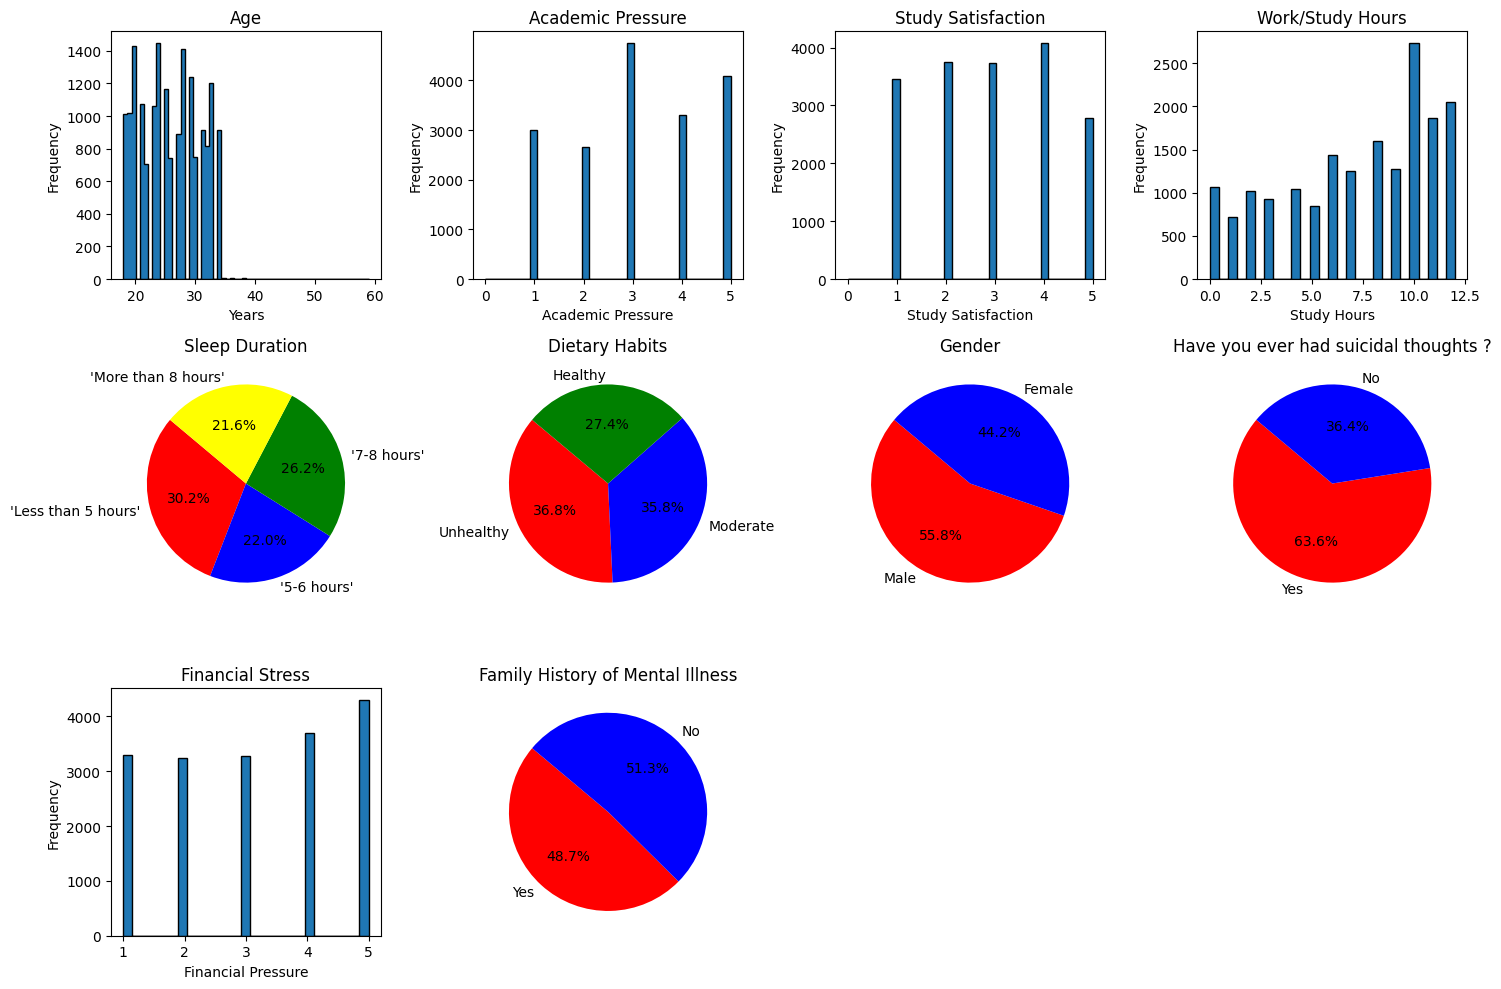

In [ ]:
# Count the frequency of a value
def count_objects(matrix):
    column = matrix.tolist()
    freq = Counter(column)
    return freq

# Calculate the percentage of each value in a pie chart
def pie_percentage_calc(matrix_slice, encode):
    percent = []
    freq = count_objects(matrix_slice)
    total = 0
    for val in freq.values():
      total += val
    for i in encode:
      percent.append((freq[i] / total) * 100)
    return percent

# Print feature names
var_name_interest = [df.columns[i] for i in vars_of_interest]
print(var_name_interest)
special_vars = [df.columns[i] for i in vars_encoded]
print(special_vars)

values = ["Years","Academic Pressure", "Study Satisfaction", "Study Hours", None, None, None, None, "Financial Pressure", None]
pie_val = {special_vars[0]:[[0,1,2,3],["'Less than 5 hours'","'5-6 hours'","'7-8 hours'", "'More than 8 hours'"],['red','blue','green','yellow']],
           special_vars[1]:[[0,1,2],["Unhealthy","Moderate","Healthy"],['red','blue','green']],
           special_vars[2]:[[1,0],["Male","Female"],['red','blue']],
           special_vars[3]:[[1,0],["Yes","No"],['red','blue']],
           special_vars[4]:[[1,0],["Yes","No"],['red','blue']]}

# 11 vars
# Plotting the distribution of these variables NOTE: DID NOT USE TRAINING OR VAL DATA
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs = axs.flatten()
for i in range(len(var_name_interest)):
  slice_ = X_train_non_scaled[:, i] #X_train_non_scaled is 10 columns long
  name = var_name_interest[i]
  # If feature is continuous, draw a histogram
  if name not in special_vars:
    axs[i].hist(slice_, bins='auto', histtype='stepfilled', edgecolor='black')
    axs[i].set_title(name)
    axs[i].set_xlabel(values[i])
    axs[i].set_ylabel("Frequency")
  # If feature is categorical, draw a pie chart
  else:
    encoding = pie_val[name][0]
    labels_ = pie_val[name][1]
    colors_ = pie_val[name][2]
    axs[i].pie(pie_percentage_calc(slice_,encoding), labels=labels_, colors=colors_, autopct='%1.1f%%', startangle=140)
    axs[i].set_title(name)

plt.axis('equal')
axs[10].axis('off')
axs[11].axis('off')
plt.tight_layout()
plt.show()



<ipython-input-58-6649fc010191>:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_depression_count = pdf.groupby(['Value_binned', 'Depression']).size().unstack(fill_value=0)
<ipython-input-58-6649fc010191>:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_depression_count = pdf.groupby(['Value_binned', 'Depression']).size().unstack(fill_value=0)
<ipython-input-58-6649fc010191>:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

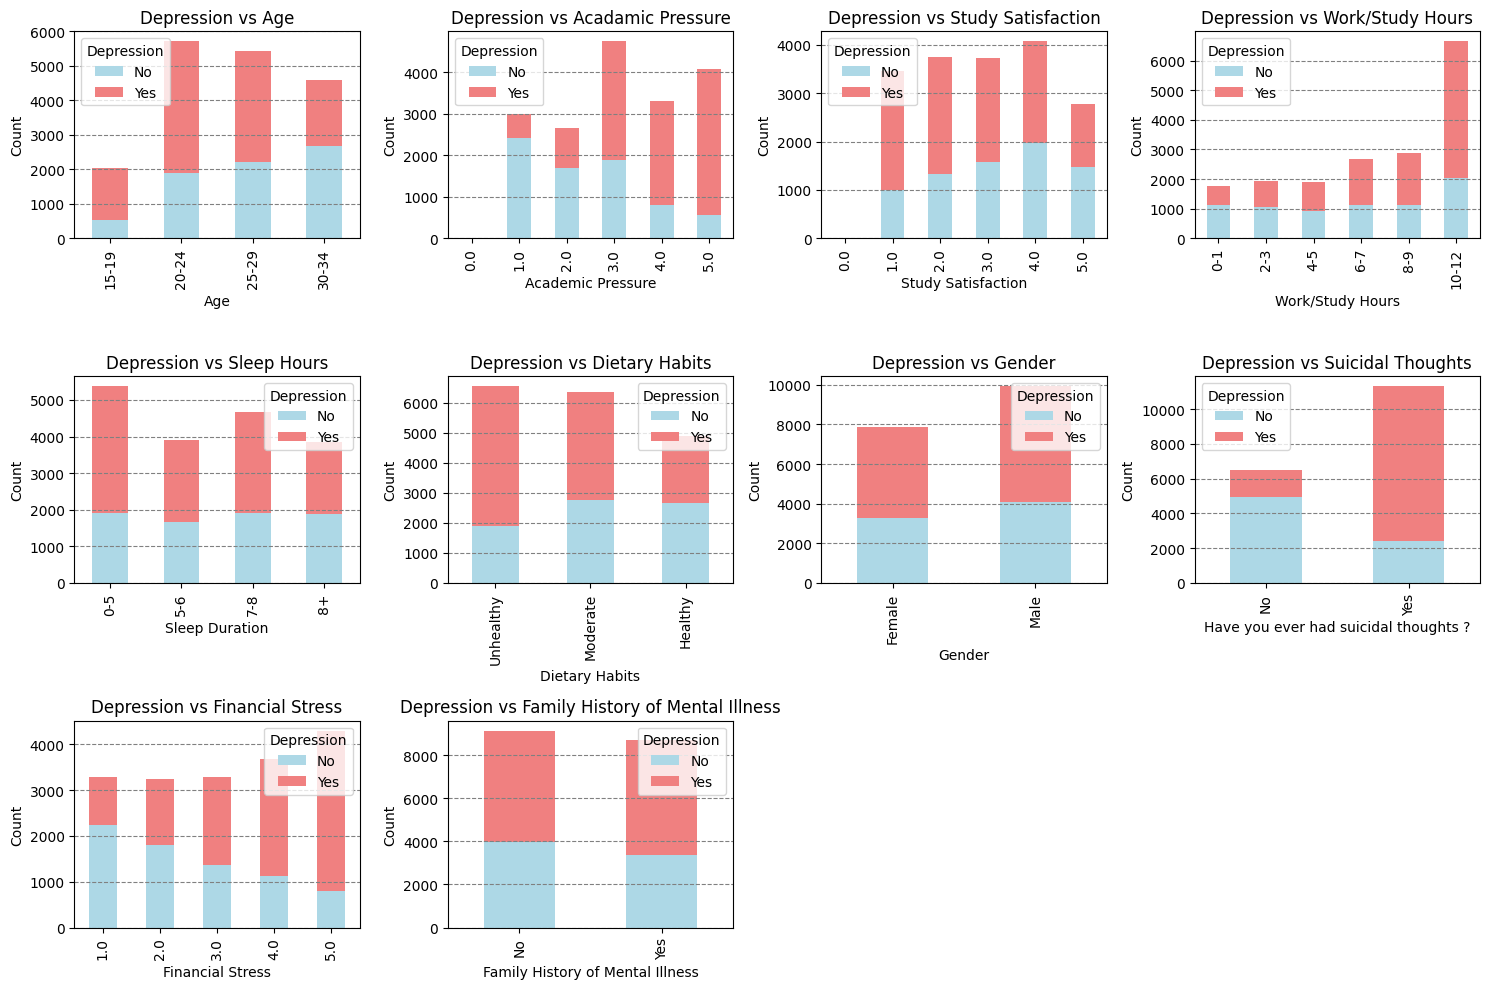

In [ ]:
# Plot with respect to target variable
binning = {0: [[15, 20, 25, 30, 35], ['15-19', '20-24', '25-29', '30-34'], "Age"],
           1: [None,"Acadamic Pressure"],
           2: [None,"Study Satisfaction"],
           3: [[0, 2, 4, 6, 8, 10, 13], ['0-1','2-3','4-5','6-7','8-9','10-12'], "Work/Study Hours"],
           4: [[0, 1, 2, 3, 4], ['0-5', '5-6', '7-8', '8+'],"Sleep Hours"],
           5: [[0, 1, 2, 3], ['Unhealthy', 'Moderate', 'Healthy'],"Dietary Habits"],
           6: [[0, 1, 2], ['Female', 'Male'],"Gender"],
           7: [[0, 1, 2], ['No', 'Yes'],"Suicidal Thoughts"],
           8: [None,"Financial Stress"],
           9: [[0, 1, 2], ['No', 'Yes'],"Family History of Mental Illness"]}

fig2, axs2 = plt.subplots(3, 4, figsize=(15, 10))
axs2 = axs2.flatten()
y_new = y_train.flatten()

for key in binning.keys():
  pdf = pd.DataFrame({   # try with the df at top later
    'Value': X_train_non_scaled[:, key],
    'Depression': y_new
  })

  if binning[key][0] is not None:
    pdf['Value_binned'] = pd.cut(pdf['Value'], bins=binning[key][0], labels=binning[key][1], right=False)
    value_depression_count = pdf.groupby(['Value_binned', 'Depression']).size().unstack(fill_value=0)
    axs2[key].set_title(f'Depression vs {binning[key][2]}')
  else:
    value_depression_count = pdf.groupby(['Value', 'Depression']).size().unstack(fill_value=0)
    axs2[key].set_title(f'Depression vs {binning[key][1]}')

  value_depression_count.plot(kind='bar', stacked=True, color=['lightblue', 'lightcoral'], ax=axs2[key])

  axs2[key].set_xlabel(var_name_interest[key])
  axs2[key].set_ylabel('Count')
  axs2[key].grid(True, axis='y', linestyle='--', color='gray')
  axs2[key].legend(title='Depression', labels=['No', 'Yes'])


axs2[10].axis('off')
axs2[11].axis('off')
plt.tight_layout()
plt.show()


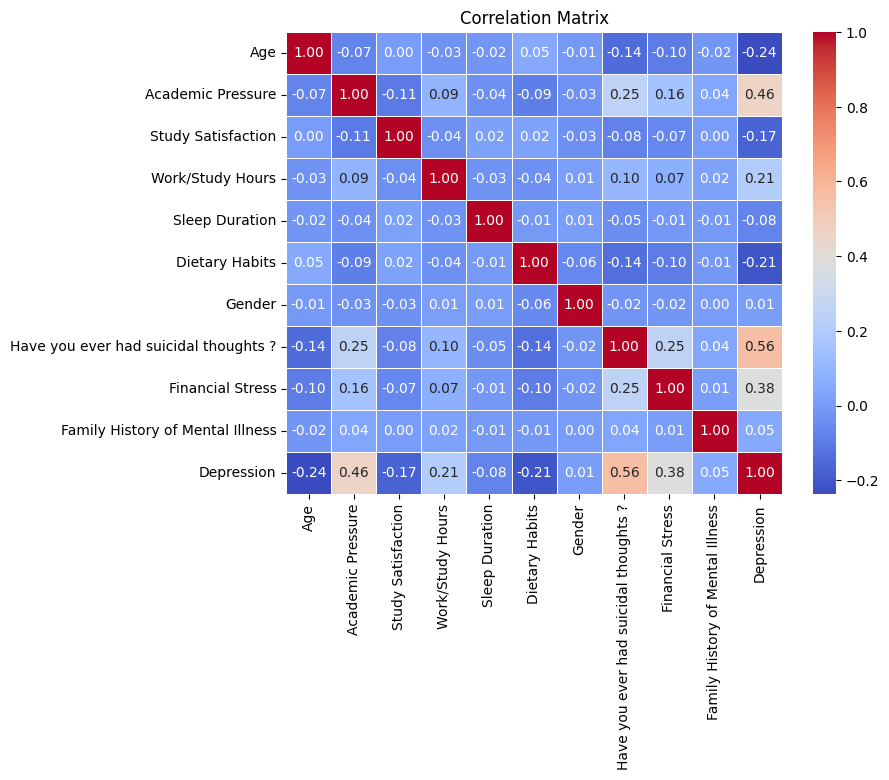

In [ ]:
# Correlation Matrix
df = pd.DataFrame(np.hstack((X_test_non_scaled, y_test)), columns=[*var_name_interest, "Depression"])
corr_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Cluster the training data
def k_means_cluster(result, k):
  kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
  kmeans.fit(X_train)
  labels = kmeans.labels_
  centers = kmeans.cluster_centers_
  loss = 0
  for i in range(X_train.shape[0]):
    loss += np.sum((X[i] - centers[labels[i]])**2)
  result.append(loss)

def em_cluster(result, k):
  gmm = GaussianMixture(n_components=k, random_state=42)
  gmm.fit(X_train)
  labels = gmm.predict(X)
  log_likelihoods = gmm.score_samples(X)
  loss = -np.sum(log_likelihoods)
  result.append(loss)

num_clusters = [1, 2, 4, 6, 8, 10]
losses = [[], []]
for k in num_clusters:
  k_means_cluster(losses[0], k)
  em_cluster(losses[1], k)

[14191660.0, 14211676.826860223, 14226942.082338043, 14238860.870513324, 14245420.220450273, 14250792.050807603]
[np.float64(11883571.061000656), np.float64(3457434229.7975125), np.float64(3457441573.084599), np.float64(6214982044.968592), np.float64(12620137866.053213), np.float64(13759339079.61949)]


<ipython-input-14-f9c897b8310c>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


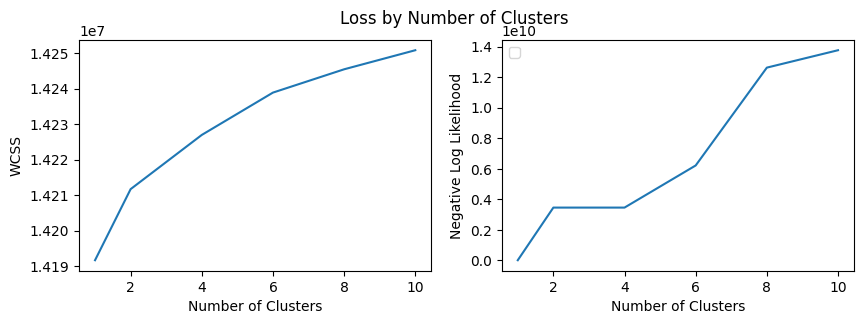

In [ ]:
# Plot results
print(losses[0])
print(losses[1])
# Plot K-Means Clustering
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(num_clusters, losses[0])
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("WCSS")
# Plot EM Clustering
axes[1].plot(num_clusters, losses[1])
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Negative Log Likelihood")
axes[1].legend()
fig.suptitle("Loss by Number of Clusters")
plt.show()

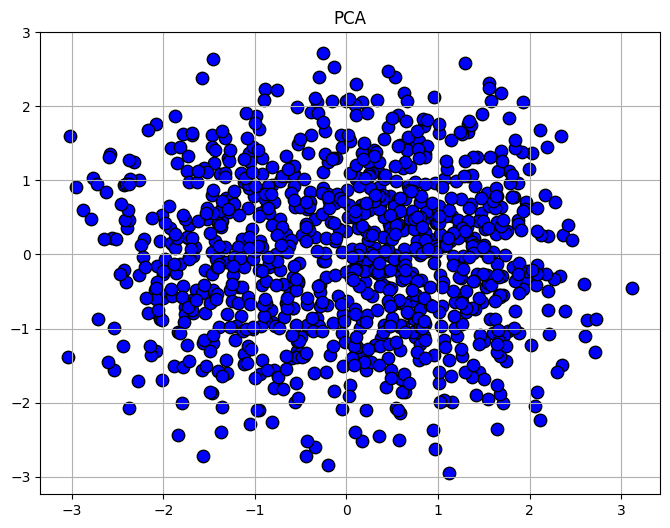

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train[:1000])
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='blue', edgecolor='k', s=80)
plt.title('PCA')
plt.grid(True)
plt.show()

## Logistic Regression

First, let's train a vanilla logistic regression model.

In [ ]:
# Sigmoid activation function
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# Calculate cross entropy error
def cross_entropy(X, y, w, lambda_):
  activation = sigmoid(X @ w)
  return -(1 / X.shape[0] * np.sum(y * np.log(activation) + (1 - y) * np.log(1 - activation)) - lambda_ / 2 * np.sum(w ** 2))

# Train logistic regression model using gradient ascent
def gradient_ascent(X, y, alpha, num_iters, lambda_, print_every=10, X_val=None, y_val=None):
  N = X.shape[0]
  w = np.zeros((X.shape[1], 1))
  errors = []
  # Shifting num_iters by 1 to ensure we print the likelihood in the final iteration
  for i in range(1, num_iters + 1):
    gradient = X.T @ (y - sigmoid(X @ w))
    regularization = lambda_ * w
    w = w + alpha * (gradient / N - regularization)
    if i % print_every == 0:
      train_cross = cross_entropy(X, y, w, lambda_)
      if X_val is not None and y_val is not None:
        val_cross = cross_entropy(X_val, y_val, w, 0)
        errors.append([i, train_cross, val_cross])
        print("Iteration:", i, "Train Cross:", train_cross, "Val Cross:", val_cross)
      else:
        errors.append([i, train_cross])
        print("Iteration:", i, "Train Cross:", train_cross)
  return w, np.array(errors)

# Predict whether a subject has depression
def predict(X, w, threshold):
  return (sigmoid(X @ w) >= threshold).astype(int)

Iteration: 10 Train Cross: 0.5458211121766593 Val Cross: 0.5475827503568426
Iteration: 20 Train Cross: 0.4746525645453092 Val Cross: 0.47734878839977796
Iteration: 30 Train Cross: 0.4355896757293152 Val Cross: 0.43880217439581687
Iteration: 40 Train Cross: 0.4118266934096023 Val Cross: 0.41533854183549773
Iteration: 50 Train Cross: 0.39626164993043594 Val Cross: 0.3999542377847839
Iteration: 60 Train Cross: 0.38550428642811835 Val Cross: 0.3893094456179593
Iteration: 70 Train Cross: 0.3777653021443716 Val Cross: 0.38164224250595435
Iteration: 80 Train Cross: 0.37202311612587424 Val Cross: 0.37594665739823024
Iteration: 90 Train Cross: 0.36765727344142307 Val Cross: 0.371611502717655
Iteration: 100 Train Cross: 0.36427185658111205 Val Cross: 0.36824654442924853
Iteration: 110 Train Cross: 0.36160386741311645 Val Cross: 0.3655923610289943
Iteration: 120 Train Cross: 0.3594727000301147 Val Cross: 0.3634706433400106
Iteration: 130 Train Cross: 0.3577508229116175 Val Cross: 0.36175535763861

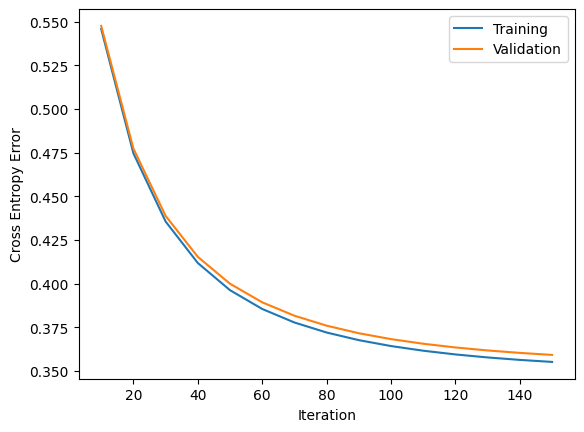

In [ ]:
# Train model
w, errors = gradient_ascent(X_train_1, y_train, alpha=0.1, num_iters=150, lambda_=0, print_every=10, X_val=X_val_1, y_val=y_val)
y_hat_val = predict(X_val_1, w, threshold)
val_accuracy, val_f1 = evaluate(y_hat_val, y_val, threshold)
print("Accuracy:", val_accuracy)
plot_errors(errors[:,0], errors[:,1], errors[:,2])

Next, let's train the logistic regression model with varying transformations and regularization. We will then evaluate its cross entropy error and F1 score on the training and validation sets.

In [ ]:
# Try different polynomial transformations
lambdas = [0, 0.001, 0.01, 0.1, 1.0, 10.0]
scores = []
for degree in range(1, 5):
  polynomial = PolynomialFeatures(degree=degree, include_bias=False)
  X_train_transformed = polynomial.fit_transform(X_train_1)
  X_val_transformed = polynomial.transform(X_val_1)
  # Try different lambdas
  for lambda_ in lambdas:
    # Train model
    print("Polynomial Degree:", degree, "Lambda:", lambda_)
    w, _ = gradient_ascent(X_train_transformed, y_train, alpha=0.1, num_iters=150, lambda_=lambda_, print_every=50)
    # Evaluate model on training set
    y_hat_training = predict(X_train_transformed, w, threshold)
    train_cross = cross_entropy(X_train_transformed, y_train, w, lambda_)
    train_accuracy, train_f1 = evaluate(y_hat_training, y_train, threshold)
    # Evaluate model on validation set
    y_hat_val = predict(X_val_transformed, w, threshold)
    val_cross = cross_entropy(X_val_transformed, y_val, w, lambda_)
    val_accuracy, val_f1 = evaluate(y_hat_val, y_val, threshold)
    scores.append([degree, lambda_, train_cross, train_accuracy, train_f1, val_cross, val_accuracy, val_f1])

Polynomial Degree: 1 Lambda: 0
Iteration: 50 Train Cross: 0.39626164993043594
Iteration: 100 Train Cross: 0.36427185658111205
Iteration: 150 Train Cross: 0.35519026001141296
Polynomial Degree: 1 Lambda: 0.001
Iteration: 50 Train Cross: 0.39716639602945475
Iteration: 100 Train Cross: 0.36575708009657976
Iteration: 150 Train Cross: 0.35700152051392875
Polynomial Degree: 1 Lambda: 0.01
Iteration: 50 Train Cross: 0.405077668990942
Iteration: 100 Train Cross: 0.3784118107137275
Iteration: 150 Train Cross: 0.3720998919433563
Polynomial Degree: 1 Lambda: 0.1
Iteration: 50 Train Cross: 0.4661061761772761
Iteration: 100 Train Cross: 0.46037646517148256
Iteration: 150 Train Cross: 0.4600850881525455
Polynomial Degree: 1 Lambda: 1.0
Iteration: 50 Train Cross: 0.6179074683966004
Iteration: 100 Train Cross: 0.617907434588402
Iteration: 150 Train Cross: 0.6179074345883765
Polynomial Degree: 1 Lambda: 10.0
Iteration: 50 Train Cross: 0.6830731593043373
Iteration: 100 Train Cross: 0.6830731593043373
It

<ipython-input-65-4321821058b8>:8: RuntimeWarning: divide by zero encountered in log
  return -(1 / X.shape[0] * np.sum(y * np.log(activation) + (1 - y) * np.log(1 - activation)) - lambda_ / 2 * np.sum(w ** 2))
<ipython-input-65-4321821058b8>:8: RuntimeWarning: invalid value encountered in multiply
  return -(1 / X.shape[0] * np.sum(y * np.log(activation) + (1 - y) * np.log(1 - activation)) - lambda_ / 2 * np.sum(w ** 2))


Iteration: 50 Train Cross: nan
Iteration: 100 Train Cross: nan
Iteration: 150 Train Cross: nan


    Degree  Lambda  T. Cross Entropy  T. Accuracy     T. F1  V. Cross Entropy  V. Accuracy     V. F1
0      1.0   0.000          0.355190     0.847968  0.872517          0.359203     0.842164  0.867384
1      1.0   0.001          0.357002     0.847912  0.872464          0.361007     0.842164  0.867384
2      1.0   0.010          0.372100     0.848192  0.872681          0.376045     0.841940  0.867220
3      1.0   0.100          0.460085     0.848248  0.872506          0.463488     0.841491  0.866641
4      1.0   1.000          0.617907     0.848080  0.871204          0.619388     0.840817  0.864978
5      1.0  10.000          0.683073     0.848080  0.870601          0.683294     0.841266  0.864689
6      2.0   0.000          0.347443     0.848417  0.873406          0.352697     0.841266  0.866730
7      2.0   0.001          0.348490     0.848305  0.873324          0.353725     0.841266  0.866730
8      2.0   0.010          0.357360     0.848361  0.873460          0.362428     0.840593 

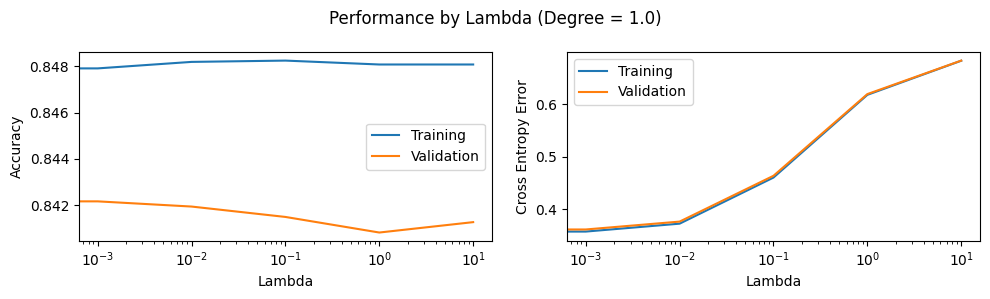

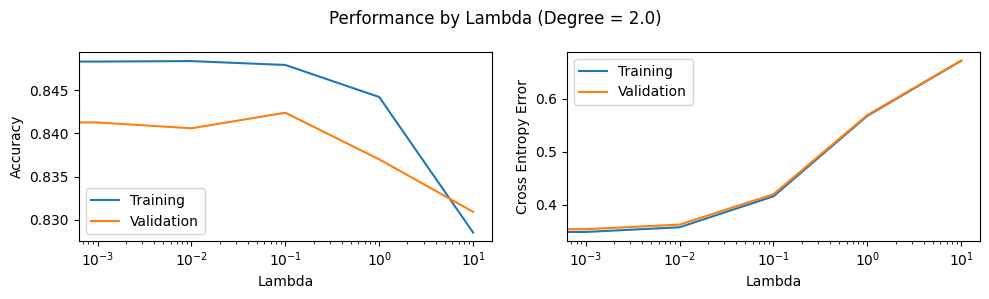

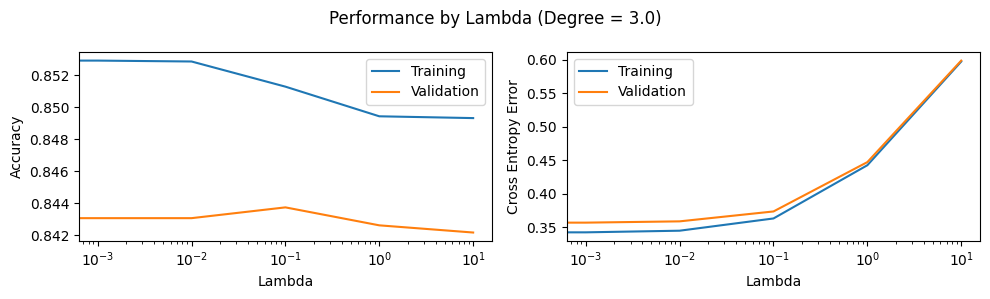

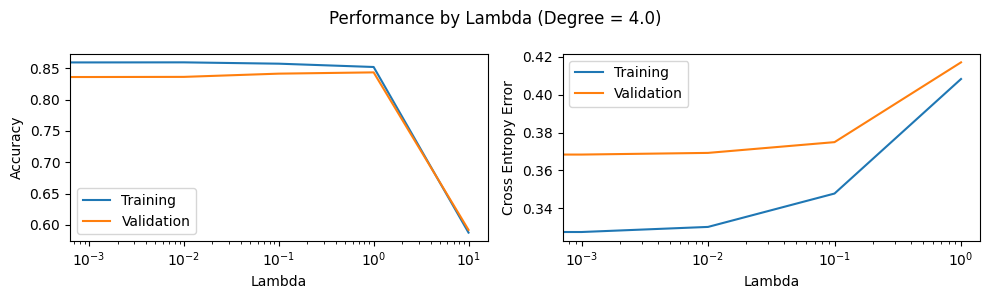

In [ ]:
plot_scores(scores, "Degree", "Lambda", len(lambdas), use_logx=True)

Now let's try varying learning rates using the optimal transformation and regularization found above.

Alpha: 0.001
Iteration: 10 Train Cross: 0.6641775352603486 Val Cross: 0.6643438337240712
Iteration: 20 Train Cross: 0.6386990191861429 Val Cross: 0.6390198791846341
Iteration: 30 Train Cross: 0.6162340201899846 Val Cross: 0.6166909580195451
Iteration: 40 Train Cross: 0.5963615810770033 Val Cross: 0.5969329655436711
Iteration: 50 Train Cross: 0.578718388362786 Val Cross: 0.5793823475614333
Iteration: 60 Train Cross: 0.5629945095775309 Val Cross: 0.5637303827907829
Iteration: 70 Train Cross: 0.5489271417970535 Val Cross: 0.5497160327440958
Iteration: 80 Train Cross: 0.5362940056567992 Val Cross: 0.5371189111355419
Iteration: 90 Train Cross: 0.5249071344939921 Val Cross: 0.5257528919115051
Iteration: 100 Train Cross: 0.5146073621401634 Val Cross: 0.5154605252210891
Iteration: 110 Train Cross: 0.5052595873692938 Val Cross: 0.5061082776507557
Iteration: 120 Train Cross: 0.4967487832475015 Val Cross: 0.4975825382844734
Iteration: 130 Train Cross: 0.4889766722778289 Val Cross: 0.4897862998677

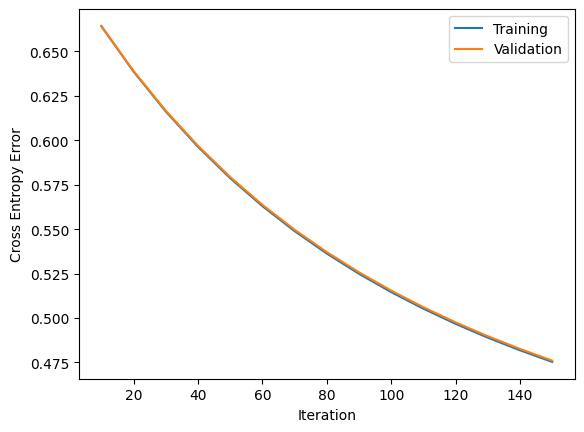

Alpha: 0.01
Iteration: 10 Train Cross: 0.5120634080159776 Val Cross: 0.5129229867600884
Iteration: 20 Train Cross: 0.4475690569317536 Val Cross: 0.4480068738398922
Iteration: 30 Train Cross: 0.4171178764838094 Val Cross: 0.416799908193654
Iteration: 40 Train Cross: 0.40029092422034607 Val Cross: 0.39918839078476254
Iteration: 50 Train Cross: 0.39006121325496235 Val Cross: 0.3882336261345824
Iteration: 60 Train Cross: 0.38343106101995544 Val Cross: 0.3809600879513046
Iteration: 70 Train Cross: 0.3789304598412274 Val Cross: 0.37589824300945746
Iteration: 80 Train Cross: 0.37576533611772595 Val Cross: 0.3722474219367705
Iteration: 90 Train Cross: 0.3734752703473465 Val Cross: 0.3695387448333695
Iteration: 100 Train Cross: 0.3717785134019768 Val Cross: 0.3674820476681892
Iteration: 110 Train Cross: 0.3704952040224758 Val Cross: 0.3658897672550687
Iteration: 120 Train Cross: 0.3695065596959695 Val Cross: 0.36463631230808724
Iteration: 130 Train Cross: 0.36873192827073953 Val Cross: 0.363635

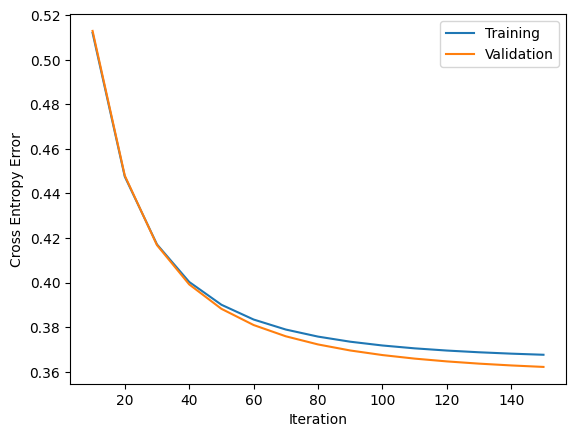

Alpha: 0.1
Iteration: 10 Train Cross: 0.37027673524522814 Val Cross: 0.3653723760400671
Iteration: 20 Train Cross: 0.36599037912239585 Val Cross: 0.3597802567153895
Iteration: 30 Train Cross: 0.36488879374656247 Val Cross: 0.35860628038190906
Iteration: 40 Train Cross: 0.3642893140992306 Val Cross: 0.3581688813056732
Iteration: 50 Train Cross: 0.36390487959148027 Val Cross: 0.3579465060094689
Iteration: 60 Train Cross: 0.3636487808290858 Val Cross: 0.3578069349469233
Iteration: 70 Train Cross: 0.36347502737042425 Val Cross: 0.35770603928745565
Iteration: 80 Train Cross: 0.36335546347997255 Val Cross: 0.35762653568052516
Iteration: 90 Train Cross: 0.3632721779022712 Val Cross: 0.35756067488295795
Iteration: 100 Train Cross: 0.36321353735175965 Val Cross: 0.35750450328927974
Iteration: 110 Train Cross: 0.3631718564811191 Val Cross: 0.3574557553023805
Iteration: 120 Train Cross: 0.3631419807890236 Val Cross: 0.3574129993295528
Iteration: 130 Train Cross: 0.36312040618545893 Val Cross: 0.3

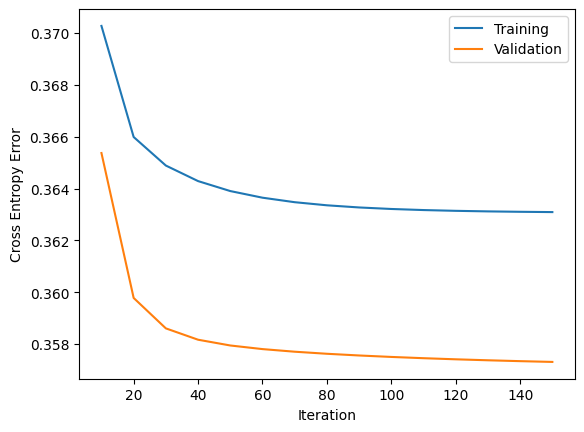

Alpha: 0.5
Iteration: 10 Train Cross: 0.36434751389165243 Val Cross: 0.3580263587955085
Iteration: 20 Train Cross: 0.3633196948459036 Val Cross: 0.3575744332504254
Iteration: 30 Train Cross: 0.36312033346177486 Val Cross: 0.35735022525708593
Iteration: 40 Train Cross: 0.36307493136685276 Val Cross: 0.35722710860324497
Iteration: 50 Train Cross: 0.3630637843753679 Val Cross: 0.35715879563706215
Iteration: 60 Train Cross: 0.36306092483815405 Val Cross: 0.35712137748811634
Iteration: 70 Train Cross: 0.36306016928084217 Val Cross: 0.35710114005511795
Iteration: 80 Train Cross: 0.3630599653049857 Val Cross: 0.3570902958268132
Iteration: 90 Train Cross: 0.3630599093305968 Val Cross: 0.3570845205259432
Iteration: 100 Train Cross: 0.3630598937729242 Val Cross: 0.35708145631844557
Iteration: 110 Train Cross: 0.3630598894046329 Val Cross: 0.35707983387598186
Iteration: 120 Train Cross: 0.3630598881680121 Val Cross: 0.3570789755686201
Iteration: 130 Train Cross: 0.3630598878155919 Val Cross: 0.35

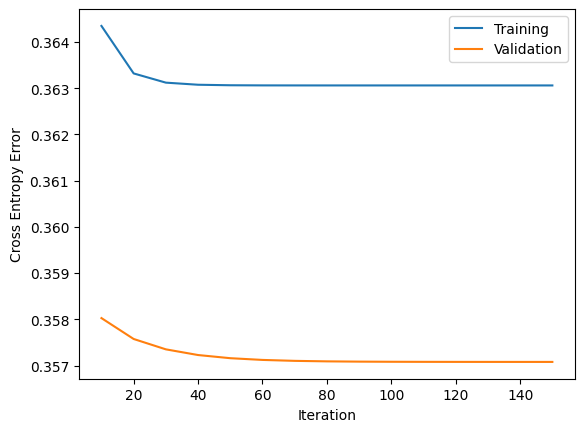

Alpha: 1.0
Iteration: 10 Train Cross: 0.4092252734786196 Val Cross: 0.39229341941218027
Iteration: 20 Train Cross: 0.6871111655820035 Val Cross: 0.6040263890849678
Iteration: 30 Train Cross: 0.568890543771448 Val Cross: 0.5289902017964704
Iteration: 40 Train Cross: 0.5092859518515611 Val Cross: 0.46578877951607595
Iteration: 50 Train Cross: 0.6329021045777471 Val Cross: 0.5670145215803114
Iteration: 60 Train Cross: 0.5965310624109188 Val Cross: 0.5491545378165029
Iteration: 70 Train Cross: 0.5153636990543431 Val Cross: 0.47335808772413573
Iteration: 80 Train Cross: 0.6102716835964704 Val Cross: 0.5462614740699274
Iteration: 90 Train Cross: 0.6172783095498855 Val Cross: 0.5668921814073027
Iteration: 100 Train Cross: 0.5056540736828301 Val Cross: 0.46621695648959527
Iteration: 110 Train Cross: 0.6084939626126394 Val Cross: 0.5429773366963396
Iteration: 120 Train Cross: 0.6236315076315365 Val Cross: 0.5735725246720694
Iteration: 130 Train Cross: 0.4944008685904189 Val Cross: 0.45663300070

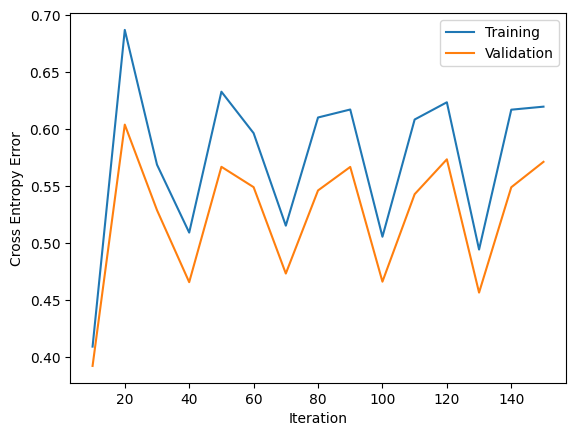

Alpha: 2.5
Iteration: 10 Train Cross: 0.4943429961756931 Val Cross: 0.4280387455636732
Iteration:

<ipython-input-65-4321821058b8>:8: RuntimeWarning: divide by zero encountered in log
  return -(1 / X.shape[0] * np.sum(y * np.log(activation) + (1 - y) * np.log(1 - activation)) - lambda_ / 2 * np.sum(w ** 2))
<ipython-input-65-4321821058b8>:8: RuntimeWarning: invalid value encountered in multiply
  return -(1 / X.shape[0] * np.sum(y * np.log(activation) + (1 - y) * np.log(1 - activation)) - lambda_ / 2 * np.sum(w ** 2))


 20 Train Cross: nan Val Cross: nan
Iteration: 30 Train Cross: 0.5101991598664677 Val Cross: 0.4499560714147929
Iteration: 40 Train Cross: 6.035697408484501 Val Cross: 5.133773521565775
Iteration: 50 Train Cross: 0.42856702593389495 Val Cross: 0.42076606618687035
Iteration: 60 Train Cross: 1.3214427158992967 Val Cross: 0.9079746456956201
Iteration: 70 Train Cross: 7.488139808390277 Val Cross: nan
Iteration: 80 Train Cross: 0.5227489114385935 Val Cross: 0.5229102507414062
Iteration: 90 Train Cross: nan Val Cross: nan
Iteration: 100 Train Cross: 4.703686599457735 Val Cross: 4.360708536181313
Iteration: 110 Train Cross: 0.3911072503755665 Val Cross: 0.3745828657719873
Iteration: 120 Train Cross: nan Val Cross: nan
Iteration: 130 Train Cross: 8.566352836556195 Val Cross: 6.609577994279187
Iteration: 140 Train Cross: 0.5445608024633566 Val Cross: 0.500333962798699
Iteration: 150 Train Cross: nan Val Cross: nan
Accuracy: 0.838796587337225


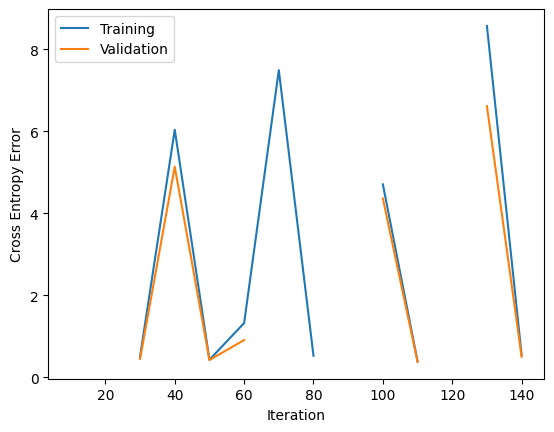

In [ ]:
# Set hyperparameters
alphas = [0.001, 0.01, 0.1, 0.5, 1.0, 2.5]
lambda_ = 0.0

# Transform data using optimal model
scores2 = []
polynomial = PolynomialFeatures(degree=3, include_bias=True)
X_train_transformed = polynomial.fit_transform(X_train_1)
X_val_transformed = polynomial.transform(X_val_1)
# Try different alphas and num_iters
for alpha in alphas:
  # Train model
  print("Alpha:", alpha)
  w, errors = gradient_ascent(X_train_transformed, y_train, alpha=alpha, num_iters=150, lambda_=0.1, print_every=10, X_val=X_val_transformed, y_val=y_val)
  y_hat_val = predict(X_val_transformed, w, threshold)
  val_accuracy, val_f1 = evaluate(y_hat_val, y_val, threshold)
  print("Accuracy:", val_accuracy)
  plot_errors(errors[:,0], errors[:,1], errors[:,2])

Finally, let's evaluate the optimal logistic regression model on the test set.

In [ ]:
# Train best model
lambda_ = 0.1
polynomial = PolynomialFeatures(degree=3, include_bias=True)
X_train_transformed = polynomial.fit_transform(X_train_1)
X_test_transformed = polynomial.transform(X_test_1)
w, _ = gradient_ascent(X_train_transformed, y_train, alpha=0.1, num_iters=200, lambda_=lambda_, print_every=1000)

# Evaluate on test set
y_hat_test = predict(X_test_transformed, w, threshold)
test_cross = cross_entropy(X_test_transformed, y_test, w, lambda_=lambda_)
test_accuracy, test_f1 = evaluate(y_hat_test, y_test, threshold)
test_scores = np.array([[test_cross, test_accuracy, test_f1]])
headers = ["Cross Entropy", "Accuracy", "F1"]
pd.set_option("display.expand_frame_repr", False)
table = pd.DataFrame(test_scores, columns=headers)
print(table)

   Cross Entropy  Accuracy        F1
0       0.373112  0.847315  0.868868


## Support Vector Machines

First, let's vary the data transformations and regularizations.

In [ ]:
# Obtain a subset of the training set
batch_size = 5000
X_train_batch = X_train[:batch_size]
y_train_batch = y_train[:batch_size]

# Define hyperparameters
transformations = [
    {'kernel': 'linear'},
    {'kernel': 'poly', 'degree': 2},
    {'kernel': 'poly', 'degree': 3},
    {'kernel': 'rbf', 'gamma': 1.0}
]
transformation_labels = ["Linear", "Degree 2", "Degree 3", "RBF"]
C_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

# Iterate over each regularization value and transformation
scores = []
for i in range(len(transformations)):
  transformation = transformations[i]
  for C in C_values:
    # Train SVM
    model = SVC(C=C, probability=True, **transformation)
    model.fit(X_train_batch, y_train_batch.reshape(y_train_batch.shape[0],))
    # Evaluate SVM on training set
    y_hat_train = model.predict(X_train_batch)
    train_scores = evaluate(y_hat_train, y_train_batch, threshold)
    train_cross = log_loss(y_train_batch, model.predict_proba(X_train_batch))
    # Evaluate SVM on validation set
    y_hat_val = model.predict(X_val)
    val_scores = evaluate(y_hat_val, y_val, threshold)
    val_cross = log_loss(y_val, model.predict_proba(X_val))
    scores.append([i, C, train_cross, train_scores[0], train_scores[1], val_cross, val_scores[0], val_scores[1]])
    print("C:", C, "Transformation:", transformation_labels[i])
    print("Train Accuracy:", train_scores[0], "Train F1:", train_scores[1], "Train Cross Entropy:", train_cross)
    print("Val Accuracy:", val_scores[0], "Val F1:", val_scores[1], "Val Cross Entropy:", val_cross)

C: 1e-05 Transformation: Linear
Train Accuracy: 0.5844 Train F1: 0.7376925018934612 Train Cross Entropy: 0.3897596202202659
Val Accuracy: 0.5918275707229457 Val F1: 0.7435825105782793 Val Cross Entropy: 0.38783028661523733
C: 0.0001 Transformation: Linear
Train Accuracy: 0.57386688 Train F1: 0.7200176609724047 Train Cross Entropy: 0.3909589948431489
Val Accuracy: 0.5794986782010954 Val F1: 0.7242066135631982 Val Cross Entropy: 0.3892241482351811
C: 0.001 Transformation: Linear
Train Accuracy: 0.52251792 Train F1: 0.607914205945147 Train Cross Entropy: 0.36479933180822877
Val Accuracy: 0.5245753175351934 Val F1: 0.6121008361058345 Val Cross Entropy: 0.3575335688584246
C: 0.01 Transformation: Linear
Train Accuracy: 0.51860176 Train F1: 0.5970213962832748 Train Cross Entropy: 0.35902214285993433
Val Accuracy: 0.5202457733385569 Val F1: 0.6008917957508279 Val Cross Entropy: 0.35205248432240294
C: 0.1 Transformation: Linear
Train Accuracy: 0.517724 Train F1: 0.59452160753321 Train Cross Ent

    Transformation        C  T. Cross Entropy  T. Accuracy     T. F1  V. Cross Entropy  V. Accuracy     V. F1
0              0.0  0.00001          0.389760     0.584400  0.737693          0.387830     0.591828  0.743583
1              0.0  0.00010          0.390959     0.573867  0.720018          0.389224     0.579499  0.724207
2              0.0  0.00100          0.364799     0.522518  0.607914          0.357534     0.524575  0.612101
3              0.0  0.01000          0.359022     0.518602  0.597021          0.352052     0.520246  0.600892
4              0.0  0.10000          0.358950     0.517724  0.594522          0.352200     0.519875  0.599911
5              0.0  1.00000          0.358989     0.517690  0.594425          0.352037     0.519545  0.599036
6              1.0  0.00001          1.118601     0.584400  0.737693          1.076452     0.591828  0.743583
7              1.0  0.00010          0.575002     0.584400  0.737693          0.565482     0.591828  0.743583
8         

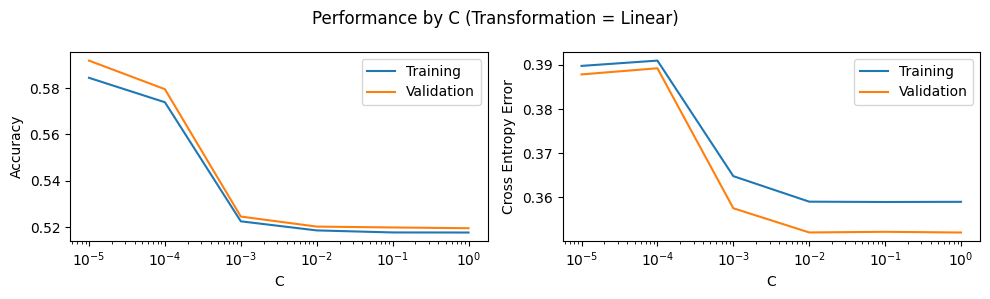

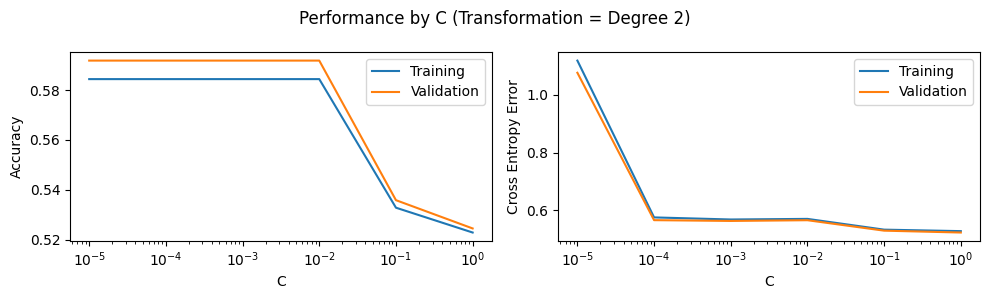

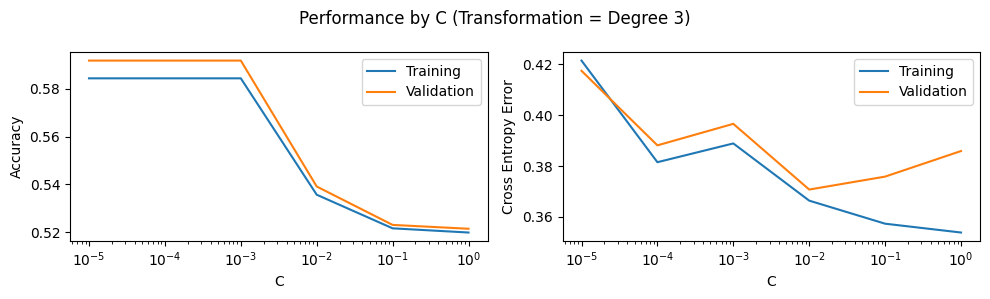

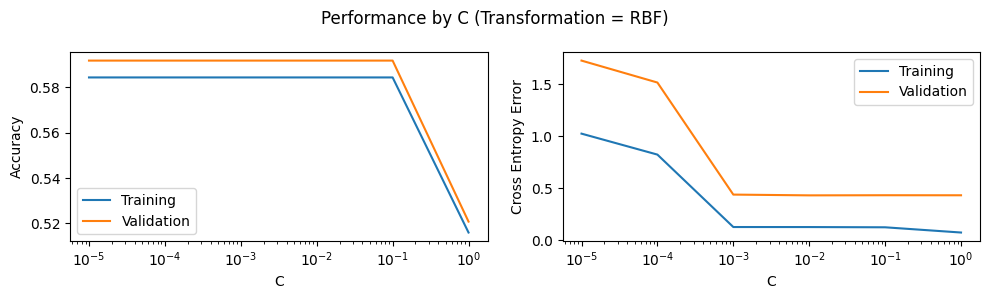

In [ ]:
plot_scores(scores, "Transformation", "C", len(C_values), chart_values=transformation_labels, use_logx=True)

Finally, let's evaluate the SVM on the test set.

In [ ]:
# Train best model
model = SVC(C=0.00001, probability=True, kernel='linear')
model.fit(X_train, y_train.reshape(y_train.shape[0],))

# Evaluate on test set
y_hat_test = model.predict(X_test)
test_scores = evaluate(y_hat_test, y_test, threshold)
test_cross = log_loss(y_test, model.predict_proba(X_test))
results = np.array([[test_cross, test_scores[0], test_scores[1]]])
headers = ["Cross Entropy", "Accuracy", "F1"]
pd.set_option("display.expand_frame_repr", False)
table = pd.DataFrame(results, columns=headers)
print(table)

   Cross Entropy  Accuracy        F1
0       0.384289  0.574097  0.729431


## Neural Networks


First, let's conver the labels into one hot encoded vectors.
3 Feature Transformations (change num of layers)
Try 6 regularization values for each (3+1)(6) = 24

Choose one of the activation functions

In [ ]:
def relu(z):  # ReLU
    return np.maximum(0, z)

def relu_deriv(z):  # ReLU derivative
    return np.where(z > 0, 1, 0)

#------------------------------------
def sigmoid(z): #Sigmoid
    return 1 / (1 + np.exp(-z))

def sigmoid_deriv(z):
    return f(z) * (1-f(z))
#------------------------------------
def tanh(z):  # tanh activation
    return np.tanh(z)

def tanh_deriv(z):  # derivative of tanh
    return 1.0 - np.tanh(z)**2
#------------------------------------
def elu(z, alpha=1.0):  # ELU
    z = np.clip(z, -100, 100)
    return np.where(z >= 0, z, alpha * (np.exp(z) - 1))

def elu_deriv(z, alpha=1.0):
    z = np.clip(z, -100, 100)
    return np.where(z >= 0, 1, alpha * np.exp(z))

Different ways to setup and initialize the weights

In [ ]:
def setup_and_init_weights(nn_structure, method='default'):
    W = {}
    b = {}
    total_layers = len(nn_structure)

    # Process all layers except output
    for l in range(1, total_layers - 1):  #Applies any of the following weight inits for the hidden layers
        n_input = nn_structure[l-1]
        n_output = nn_structure[l]

        if method == 'he': # Good for RELU, ELU
            W[l] = np.random.randn(n_output, n_input) * np.sqrt(2.0 / n_input)
        elif method == 'xavier': # Good for Tanh, Sigmoid
            W[l] = np.random.randn(n_output, n_input) * np.sqrt(1.0 / n_input)
        elif method == 'default':
            W[l] = np.random.random_sample((n_output, n_input))
        else:
            raise ValueError("Invalid initialization method")
        b[l] = np.zeros((n_output,))

    # Force Xavier for output layer (last weight matrix) (need this for binary classification)
    output_layer_idx = total_layers - 1
    n_input = nn_structure[output_layer_idx - 1]
    n_output = nn_structure[output_layer_idx]
    W[output_layer_idx] = np.random.randn(n_output, n_input) * np.sqrt(1.0 / n_input)
    b[output_layer_idx] = np.zeros((n_output,))

    return W, b


Initialize gradient weights in all layers to 0

In [ ]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

Feed Forward (Note using ELU for hidden layers and sigmoid for last)

In [ ]:
# def feed_forward(x, W, b):
#     a = {1: x} # create a dictionary for holding the a values for all levels
#     z = { } # create a dictionary for holding the z values for all the layers
#     for l in range(1, len(W) + 1): # for each layer
#         node_in = a[l]
#         z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
#         a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
#     return a, z

def feed_forward(x, W, b):
    a = {1: x}
    z = {}
    for l in range(1, len(W) + 1):
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]
        # Use ELU for hidden layers, sigmoid for final layer
        activation = elu if l < len(W) else sigmoid
        a[l+1] = activation(z[l+1])
    return a, z

Calculate δ for all layers. Note our cost function is cross entropy error

In [ ]:
def binary_ce(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred))

def calculate_out_layer_delta(y, a_out): #Using cross entropy error + sigmoid
    return a_out - y

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * elu_deriv(z_l)

Back-Propagation Algorithm (Uses L2 Regularization)

In [ ]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25, lambda_reg = 0.01):
    W, b = setup_and_init_weights(nn_structure, method='he')
    cnt = 1
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations (lambda = {})'.format(iter_num, lambda_reg))
    while cnt < iter_num + 1:
        if cnt % 20 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure): # Output layer
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l])
                    avg_cost += binary_ce(y[i,:], a[l])
                else:   # Hidden layers
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(1, len(nn_structure)):
            W[l] -= alpha * ((tri_W[l]/N) + (lambda_reg/N) * W[l])
            b[l] -= alpha * (tri_b[l]/N)
        # complete the average cost calculation
        reg_term = 0.5 * lambda_reg * sum(np.sum(W[l]**2) for l in W)
        avg_cost = (avg_cost/N) + reg_term/N

        if cnt % 10 == 0:
          avg_cost_func.append([cnt, avg_cost])

        cnt += 1

    return W, b, avg_cost_func

def predict_y(W, b, X, threshold=0.5):
  N = X.shape[0]
  y_pred = np.zeros(N)
  for i in range(N):
      a, _ = feed_forward(X[i], W, b)
      # Get output layer activation (single value)
      output_prob = a[len(W)+1]
      # Apply threshold to convert probability to class (0 or 1)
      if output_prob >= threshold:
          y_pred[i] = 1
      else:
          y_pred[i] = 0
  return y_pred


Train a vanilla neural network.

In [ ]:
W, b, avg_cost_func = train_nn([X_train.shape[1], 5, 1], X_train, y_train, iter_num=100, lambda_reg=0)
y_pred = predict_y(W, b, X_val)
print('Prediction accuracy is {}%'.format(accuracy_score(y_val, y_pred) * 100))
print(pd.DataFrame(avg_cost_func, columns=["Iteration", "Cross Entropy Loss"]))

Starting gradient descent for 100 iterations (lambda = 0)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Prediction accuracy is 83.9021104625056%
   Iteration  Cross Entropy Loss
0         10            0.541510
1         20            0.449935
2         30            0.403613
3         40            0.381928
4         50            0.371817
5         60            0.366823
6         70            0.364118
7         80            0.362477
8         90            0.361354
9        100            0.360503


In [ ]:
y_pred = predict_y(W, b, X_train)
print('Prediction accuracy is {}%'.format(accuracy_score(y_train, y_pred) * 100))

Prediction accuracy is 84.44868627891309%


Plotting Results


In [ ]:
def evaluate_model(nn_structure, X_train, y_train, X_val, y_val, lambdas, iter_num=100, alpha=0.25):
    """
    Evaluates model performance across different regularization strengths.

    Returns:
    {
        'reg': [λ1, λ2, ...],
        'train_acc': [acc1, acc2, ...],
        'train_f1': [p1, p2, ...],
        'val_acc': [r1, r2, ...],
        'val_f1': [f1, f2, ...]
    }
    """
    results = {
        'reg': [],
        'train_acc': [],
        'train_f1': [],
        'val_acc': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }

    for lam in lambdas:
      # Train model with current regularization
      W, b, _ = train_nn(nn_structure, X_train, y_train, iter_num=iter_num, alpha=alpha, lambda_reg=lam)

      # Get predictions
      y_train_pred = predict_y(W, b, X_train)
      y_val_pred = predict_y(W, b, X_val)

      # Calculate metrics
      train_acc = np.mean(y_train_pred == y_train.squeeze())
      train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
      val_acc = np.mean(y_val_pred == y_val.squeeze())
      val_f1 = f1_score(y_val, y_val_pred, zero_division=0)
      val_precision = precision_score(y_val, y_val_pred, zero_division=0)
      val_recall = recall_score(y_val, y_val_pred, zero_division=0)

      # Store results
      results['reg'].append(lam)
      results['train_acc'].append(train_acc)
      results['train_f1'].append(train_f1)
      results['val_acc'].append(val_acc)
      results['val_f1'].append(val_f1)
      results['val_precision'].append(val_precision)
      results['val_recall'].append(val_recall)

    return results

def show_results_table(results_dict):
    """
    Displays a table with training accuracy and validation metrics
    for different regularization values.

    results_dict format:
    {
        'reg': [val1, val2, ..., val6],
        'train_acc': [...],
        'train_f1': [...],
        'val_acc': [...],
        'val_f1': [...]
    }
    """
    df = pd.DataFrame(results_dict)
    df.columns = ['Reg. Strength', 'Train Accuracy', 'Train F1', 'Val Accuracy', 'Val F1', 'Val Precision', 'Val Recall']
    print("\nModel Evaluation Table:\n")
    print(df.to_string(index=False, float_format="%.4f"))

def plot_performance_vs_regularization(results):
    x_val = results['reg']
    plt.figure(figsize=(10,6))
    plt.plot(x_val, results['train_acc'], marker='o', label='Train Accuracy', color='#00bcd4')
    plt.plot(x_val, results['train_f1'], marker='o', label='Train F1', color='#ffb74d')
    plt.plot(x_val, results['val_acc'], marker='o', label='Val Accuracy', color='#b71c1c')
    plt.plot(x_val, results['val_f1'], marker='o', label='Val F1', color='#4de320')
    plt.plot(x_val, results['val_precision'], marker='o', label='Val Precision', color='#8e24aa')
    plt.plot(x_val, results['val_recall'], marker='o', label='Val Recall', color='#f44336')

    plt.xscale('log')
    plt.xlabel('Regularization Strength (log scale)', fontsize=14)
    plt.ylabel('Performance Metrics', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

NN Structure: [10, 8, 1]
Starting gradient descent for 100 iterations (lambda = 0)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 0.001)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 0.01)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 0.1)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 1.0)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 10.0)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100



Mode

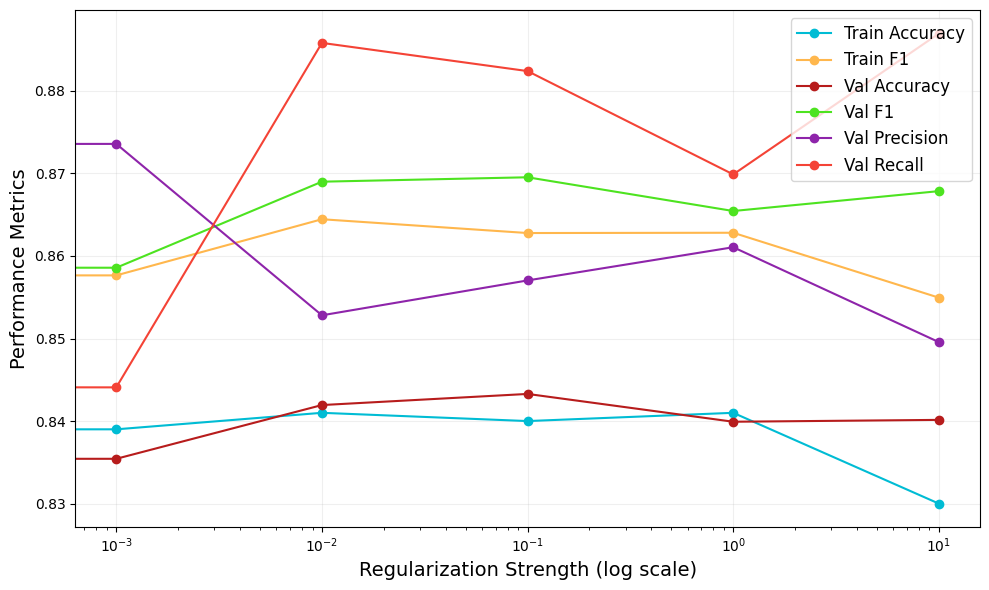

NN Structure: [10, 20, 1]
Starting gradient descent for 100 iterations (lambda = 0)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 0.001)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 0.01)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 0.1)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 1.0)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 10.0)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100



Mod

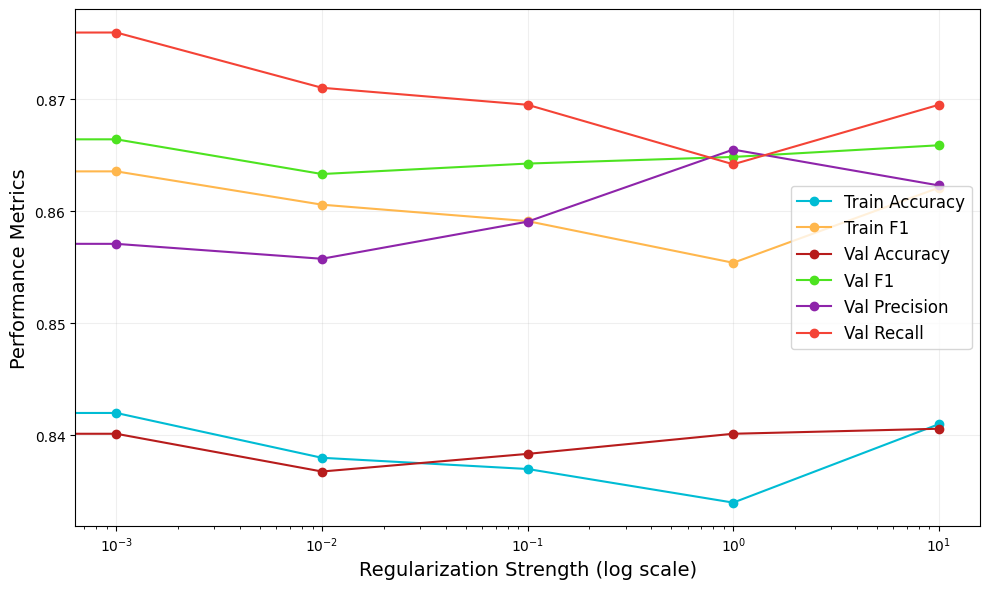

NN Structure: [10, 16, 8, 1]
Starting gradient descent for 100 iterations (lambda = 0)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 0.001)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 0.01)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 0.1)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 1.0)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100
Starting gradient descent for 100 iterations (lambda = 10.0)
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100
Iteration 100 of 100





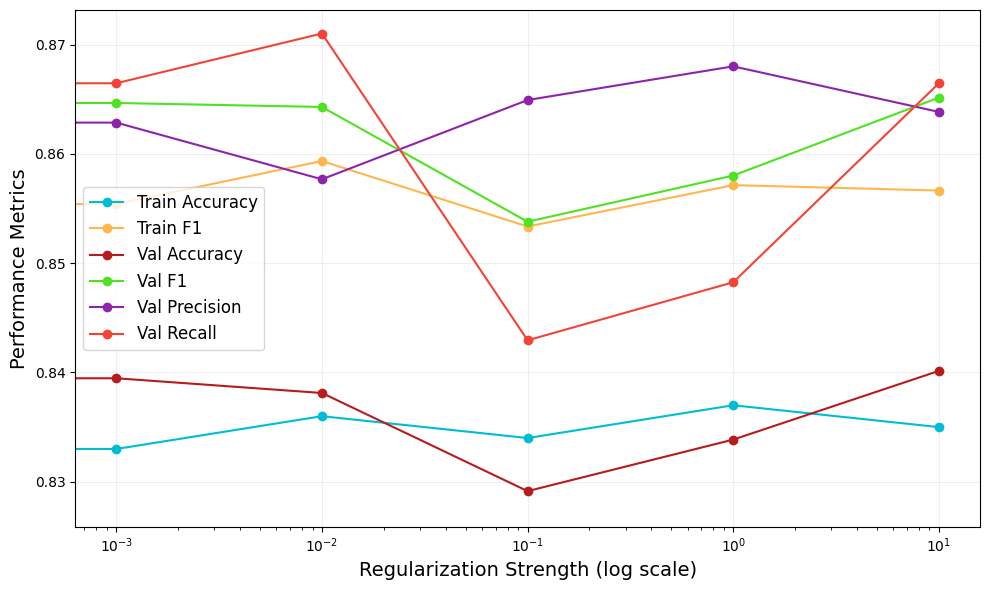

In [ ]:
# Takes a lot of time
nn_structures = [
    [X_train.shape[1], 8, 1],
    [X_train.shape[1], 20, 1],
    [X_train.shape[1], 16, 8, 1],
]
lambdas = [0, 0.001, 0.01, 0.1, 1.0, 10.0]

for nn_structure in nn_structures:
  print("NN Structure:", nn_structure)
  results = evaluate_model(nn_structure, X_train[:1000,], y_train[:1000,], X_val, y_val, lambdas, iter_num=100, alpha=0.25)
  print("\n=======================================================\n")
  show_results_table(results)
  print("\n=======================================================\n")
  plot_performance_vs_regularization(results)


Better algo

In [ ]:
def train_nn_optimized(nn_structure, X, y, X_val=None, y_val=None, iter_num=3000,
                      alpha=0.25, lambda_reg=0.01, batch_size=32,
                      early_stop_patience=5, lr_decay=0.95, lr_decay_steps=500):
    """
    Optimized neural network training with batching, Adam optimizer,
    early stopping, and learning rate decay.
    """
    W, b = setup_and_init_weights(nn_structure, method='he')

    # Initialize Adam optimizer parameters
    m_W, v_W = {}, {}
    m_b, v_b = {}, {}
    for l in W:
        m_W[l] = np.zeros_like(W[l])
        v_W[l] = np.zeros_like(W[l])
        m_b[l] = np.zeros_like(b[l])
        v_b[l] = np.zeros_like(b[l])

    beta1, beta2 = 0.9, 0.999  # Adam parameters
    epsilon = 1e-8
    t = 0  # Time step for Adam

    N = X.shape[0]
    num_batches = (N + batch_size - 1) // batch_size  # Ceiling division
    indices = np.arange(N)

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_W, best_b = None, None

    avg_cost_func = []
    print(f'Starting optimized training for {iter_num} iterations')

    for epoch in range(iter_num):
        if epoch % 100 == 0:
            print(f'Iteration {epoch} of {iter_num}')

        # Learning rate decay
        current_alpha = alpha * (lr_decay ** (epoch // lr_decay_steps))

        # Shuffle data for each epoch
        np.random.shuffle(indices)
        epoch_cost = 0

        # Process mini-batches
        for batch_idx in range(num_batches):
            t += 1  # Increment Adam time step

            # Get batch indices
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, N)
            batch_indices = indices[start_idx:end_idx]
            batch_size_actual = len(batch_indices)

            # Process batch
            tri_W, tri_b = init_tri_values(nn_structure)
            batch_cost = 0

            # Vectorized forward pass for all samples in batch (still loop for simplicity)
            for i in batch_indices:
                a, z = feed_forward(X[i, :], W, b)
                delta = {}

                # Backpropagation
                for l in range(len(nn_structure), 0, -1):
                    if l == len(nn_structure):  # Output layer
                        delta[l] = calculate_out_layer_delta(y[i,:], a[l])
                        batch_cost += binary_ce(y[i,:], a[l])
                    else:  # Hidden layers
                        if l > 1:
                            delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                        if l > 0:  # Accumulate gradients
                            tri_W[l] += np.outer(delta[l+1], a[l])
                            tri_b[l] += delta[l+1]

            # Adam optimizer update for each layer
            for l in range(1, len(nn_structure)):
                # Compute gradients including regularization
                grad_W = tri_W[l]/batch_size_actual + lambda_reg * W[l]/N
                grad_b = tri_b[l]/batch_size_actual

                # Adam update for weights
                m_W[l] = beta1 * m_W[l] + (1 - beta1) * grad_W
                v_W[l] = beta2 * v_W[l] + (1 - beta2) * (grad_W**2)
                m_W_hat = m_W[l] / (1 - beta1**t)
                v_W_hat = v_W[l] / (1 - beta2**t)
                W[l] -= current_alpha * m_W_hat / (np.sqrt(v_W_hat) + epsilon)

                # Adam update for biases
                m_b[l] = beta1 * m_b[l] + (1 - beta1) * grad_b
                v_b[l] = beta2 * v_b[l] + (1 - beta2) * (grad_b**2)
                m_b_hat = m_b[l] / (1 - beta1**t)
                v_b_hat = v_b[l] / (1 - beta2**t)
                b[l] -= current_alpha * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

            epoch_cost += batch_cost / batch_size_actual

        # Regularization term for cost calculation
        reg_term = 0.5 * lambda_reg * sum(np.sum(W[l]**2) for l in W.keys())
        avg_cost = epoch_cost/num_batches + reg_term/N
        avg_cost_func.append(avg_cost)

        # Evaluate on validation set if provided (for early stopping)
        if X_val is not None and y_val is not None:
            val_cost = 0
            for i in range(len(y_val)):
                a_val, _ = feed_forward(X_val[i, :], W, b)
                val_cost += binary_ce(y_val[i,:], a_val[len(nn_structure)])
            val_cost = val_cost/len(y_val) + reg_term/N

            # Early stopping check
            if val_cost < best_val_loss:
                best_val_loss = val_cost
                patience_counter = 0
                # Save best model
                best_W = {k: v.copy() for k, v in W.items()}
                best_b = {k: v.copy() for k, v in b.items()}
            else:
                patience_counter += 1
                if patience_counter >= early_stop_patience:
                    print(f"Early stopping at iteration {epoch}")
                    # Restore best model
                    W, b = best_W, best_b
                    break

    # Return best model if early stopping was used
    if X_val is not None and best_W is not None:
        return best_W, best_b, avg_cost_func

    return W, b, avg_cost_func


Evaluate the best model against the test set

In [ ]:
# Get predictions
W, b, avg_cost_func = train_nn([X_train.shape[1], 8, 1], X_train, y_train, iter_num=500, alpha=0.25, lambda_reg=0.1)
y_train_pred = predict_y(W, b, X_train)
y_test_pred = predict_y(W, b, X_test)
print(pd.DataFrame(avg_cost_func, columns=["Iteration", "Cross Entropy Loss"]))

# Calculate metrics
train_acc = np.mean(y_train_pred == y_train.squeeze())
train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
test_acc = np.mean(y_test_pred == y_test.squeeze())
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

# Print metrics
results = np.array([[train_acc, train_f1, test_acc, test_f1]])
headers = ["Train Accuracy", "Train F1", "Test Accuracy", "Test F1"]
pd.set_option("display.expand_frame_repr", False)
table = pd.DataFrame(results, columns=headers)
print(table)

Starting gradient descent for 500 iterations (lambda = 0.1)
Iteration 20 of 500
Iteration 40 of 500
Iteration 60 of 500
Iteration 80 of 500
Iteration 100 of 500
Iteration 120 of 500
Iteration 140 of 500
Iteration 160 of 500
Iteration 180 of 500
Iteration 200 of 500
Iteration 220 of 500
Iteration 240 of 500
Iteration 260 of 500
Iteration 280 of 500
Iteration 300 of 500
Iteration 320 of 500
Iteration 340 of 500
Iteration 360 of 500
Iteration 380 of 500
Iteration 400 of 500
Iteration 420 of 500
Iteration 440 of 500
Iteration 460 of 500
Iteration 480 of 500
Iteration 500 of 500
    Iteration  Cross Entropy Loss
0          10            0.482182
1          20            0.405060
2          30            0.377160
3          40            0.365608
4          50            0.360543
5          60            0.358167
6          70            0.356936
7          80            0.356205
8          90            0.355701
9         100            0.355307
10        110            0.354972
11        1

In [ ]:
# Get predictions
W, b, avg_cost_func = train_nn([X_train.shape[1], 5, 1], X_train, y_train, iter_num=500, alpha=0.25, lambda_reg=0)
y_train_pred = predict_y(W, b, X_train)
y_test_pred = predict_y(W, b, X_test)
print(pd.DataFrame(avg_cost_func, columns=["Iteration", "Cross Entropy Loss"]))

# Calculate metrics
train_acc = np.mean(y_train_pred == y_train.squeeze())
train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
test_acc = np.mean(y_test_pred == y_test.squeeze())
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

# Print metrics
results = np.array([[train_acc, train_f1, test_acc, test_f1]])
headers = ["Train Accuracy", "Train F1", "Test Accuracy", "Test F1"]
pd.set_option("display.expand_frame_repr", False)
table = pd.DataFrame(results, columns=headers)
print(table)

Starting gradient descent for 500 iterations (lambda = 0)
Iteration 20 of 500
Iteration 40 of 500
Iteration 60 of 500
Iteration 80 of 500
Iteration 100 of 500
Iteration 120 of 500
Iteration 140 of 500
Iteration 160 of 500
Iteration 180 of 500
Iteration 200 of 500
Iteration 220 of 500
Iteration 240 of 500
Iteration 260 of 500
Iteration 280 of 500
Iteration 300 of 500
Iteration 320 of 500
Iteration 340 of 500
Iteration 360 of 500
Iteration 380 of 500
Iteration 400 of 500
Iteration 420 of 500
Iteration 440 of 500
Iteration 460 of 500
Iteration 480 of 500
Iteration 500 of 500
    Iteration  Cross Entropy Loss
0          10            0.506241
1          20            0.436457
2          30            0.401100
3          40            0.381764
4          50            0.371304
5          60            0.365676
6          70            0.362595
7          80            0.360829
8          90            0.359735
9         100            0.358985
10        110            0.358415
11        120